In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Dropout, Flatten, Reshape, Conv2DTranspose
from tensorflow.keras.models import Model, Sequential

In [60]:
train, test = tfds.load('emnist', split = ['train', 'test'], batch_size = 64, shuffle_files = True, 
                        download_and_prepare_kwargs={'download_config':tfds.download.DownloadConfig(max_examples_per_split=1000)})

In [61]:
for example in train.take(1).as_numpy_iterator():
  print(example['image'].shape)
  print(example['label'].shape)

(64, 28, 28, 1)
(64,)


In [62]:
def sample(example):
  image = example['image']
  label = example['label']
  image = tf.image.convert_image_dtype(image, tf.float32)
  return image, image

def extract_labels(example):
  image = example['image']
  label = example['label']
  return label

In [63]:
labels = train.map(extract_labels)
train = train.map(sample)


(64, 28, 28, 1)
(64, 28, 28, 1)


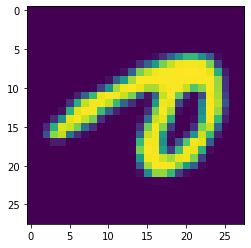

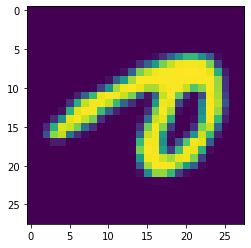

In [64]:
for image1, image2 in train.take(1).as_numpy_iterator():
  print(image1.shape)
  print(image2.shape)
  plt.imshow(image1[0])
  plt.show()
  plt.imshow(image2[0])
  plt.show()

In [65]:
def build_encoder(input, input_shape = (28, 28, 1), LATENT_SIZE = 32):

  inp = Conv2D(16, kernel_size = (3,3), padding = 'same')(input)
  inp = MaxPooling2D(pool_size = (3,3), padding = 'same')(inp)

  inp = Conv2D(32, kernel_size = (3,3), padding = 'same')(inp)
  inp = MaxPooling2D(pool_size = (3,3), padding = 'same')(inp)

  inp = Flatten()(inp)
  inp = Dense(512, activation = 'relu')(inp)
  inp = Dropout(0.5)(inp)

  inp = Dense(256, activation = 'relu')(inp)
  inp = Dropout(0.5)(inp)

  inp = Dense(128, activation = 'relu')(inp)
  inp = Dropout(0.5)(inp)

  inp = Dense(64, activation = 'relu')(inp)
  inp = Dropout(0.5)(inp)

  output = Dense(LATENT_SIZE, activation = 'relu', name = 'LATENT_VECTOR')(inp)

  return output

def build_decoder(input, output_shape = (28, 28, 1), LATENT_SIZE = 32):
  # input = Input(shape = (LATENT_SIZE,))

  inp = Dense(64, activation = 'relu')(input)
  inp = Dropout(0.5)(inp)

  inp = Dense(128, activation = 'relu')(inp)
  inp = Dropout(0.5)(inp)

  inp = Dense(256, activation = 'relu')(inp)
  inp = Dropout(0.5)(inp)

  inp = Dense(512, activation = 'relu')(inp)
  inp = Dropout(0.5)(inp)

  inp = Dense(784, activation = 'sigmoid')(inp)

  output = Reshape(target_shape = output_shape)(inp)

  return output

def build_model(input_shape = (28, 28, 1), LATENT_SIZE = 32, output_shape = (28, 28, 1)):
  input = Input(shape = input_shape)

  latent_vector = build_encoder(input, input_shape = input_shape, LATENT_SIZE = LATENT_SIZE)
  output = build_decoder(latent_vector, output_shape = output_shape, LATENT_SIZE = LATENT_SIZE)

  # latent_vector = encoder(input)
  # output = decoder(latent_vector)

  return Model(inputs = input, outputs = output)

  

In [66]:
model = build_model(input_shape = (28, 28, 1), LATENT_SIZE = 10, output_shape = (28, 28, 1))
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_14 (Conv2D)          (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 10, 10, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_15 (Conv2D)          (None, 10, 10, 32)        4640      
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 4, 4, 32)         0         
 g2D)                                                            
                                                                 
 flatten_7 (Flatten)         (None, 512)               0  

In [67]:
model.input

<KerasTensor: shape=(None, 28, 28, 1) dtype=float32 (created by layer 'input_11')>

In [68]:
model.get_layer('LATENT_VECTOR').output

<KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'LATENT_VECTOR')>

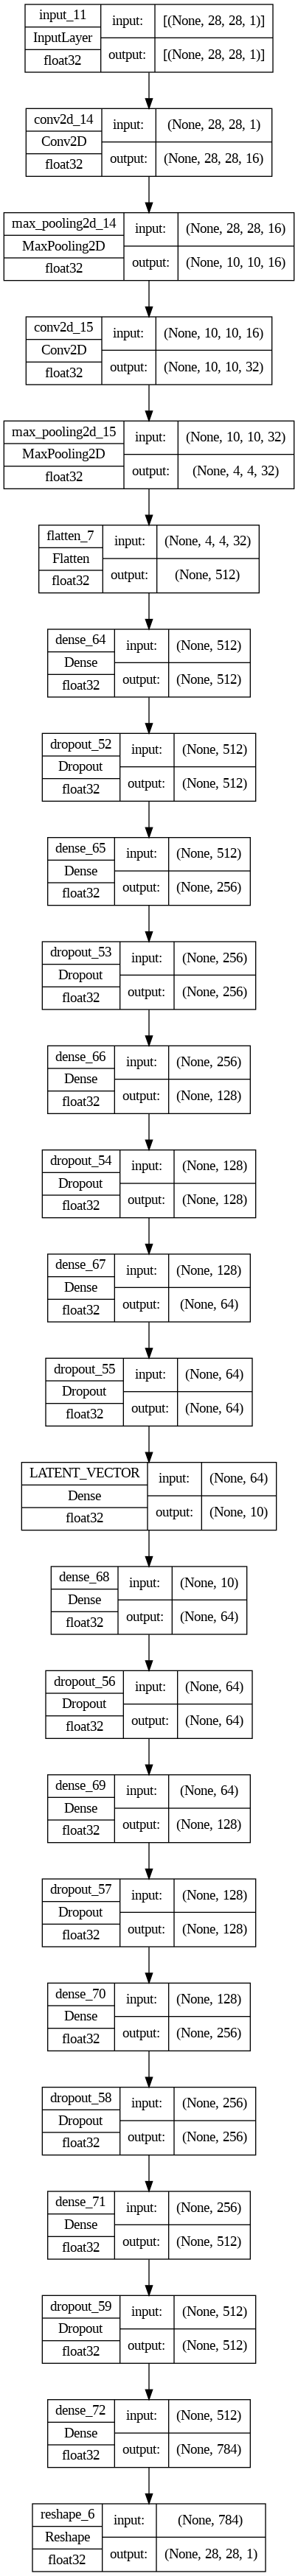

In [69]:
tf.keras.utils.plot_model(model, show_shapes=True, show_dtype=True)

Make TSNE model for representing latent vector

In [70]:
tSNE = Model(inputs = model.input, outputs = model.get_layer('LATENT_VECTOR').output)

In [71]:
from sklearn.manifold import TSNE

In [72]:
features = tSNE.predict(image1)

2/2 [==============================] - 0s 27ms/step


In [73]:
features.shape

(64, 10)

In [74]:
tsne = TSNE(n_components = 2).fit_transform(features)

In [75]:
def scale_to_01_range(x):

    value_range = (np.max(x) - np.min(x))
    starts_from_zero = x - np.min(x)
    return starts_from_zero / value_range

In [76]:
tx = tsne[:, 0]
ty = tsne[:, 1]

tx = scale_to_01_range(tx)
ty = scale_to_01_range(ty)

In [122]:
arr = tfds.as_numpy(labels.take(1))
labels = []
for label in arr:
  labels.append(label)

In [123]:
labels = labels[0]
labels = labels.tolist()

<ipython-input-125-b54be5ceb1b2>:15: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(current_tx, current_ty,c = colors[idx])


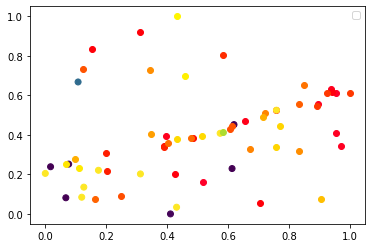

In [125]:
un_labels = list(np.unique(new_labels))

cm = plt.get_cmap('gist_rainbow')
fig = plt.figure()
ax = fig.add_subplot(111)
colors = [cm(l) for l in un_labels]

for idx, lab in enumerate(un_labels):
  indices = []
  for i, l in enumerate(labels):
    if lab == l:
      indices.append(i)
  current_tx = tx[indices]
  current_ty = ty[indices]
  ax.scatter(current_tx, current_ty,c = colors[idx])

ax.legend(loc='best')
plt.show()